# Full-Learning PC Networks
Purpose: To see if we can learn not only (v)<->(e) connections, but also the (e)<->(v) connections. Those connections have previously been set to 1:1 identity mappings. But here they start as random connection weights, and learn using the same update rule as the other learning connections.

In [1097]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from ipywidgets import FloatProgress

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [1357]:
# Make my own dataset
A = torch.tensor([[ 1.3874, -0.2003,  0.4514],
                  [-0.0967, -0.4015,  1.3332]], dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

In [626]:
# Make my own dataset
A = torch.eye(2, dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

In [1358]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, noise=0.1):
        self.samples = []
        self.n_classes = len(A)
        self.input_dim = len(A[0])
        for i in range(n):
            r = np.random.randint(self.n_classes)
            #sample = [A[r]+noise*torch.randn_like(A[r]), B[r]]
            sample = [A[r]+noise*torch.randn_like(A[r]), B[r]+noise*torch.randn_like(B[r])]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)
    
    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)
    
    def ClassMean(self):
        xmean = []
        for c_idx in range(self.n_classes):
            classmean = torch.mean(self.InputsOfClass(c_idx), axis=0)
            xmean.append(classmean)
        return torch.stack(xmean)
            
    def Plot(self, labels=[], idx=(1,2), equal=True):
        X = self.Inputs()
        if len(labels)==0:
            labels = self.Targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = torch.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,idx[0]], X[:,idx[1]], color=colours, marker='.')

        if equal:
            plt.axis('equal');

In [1485]:
blah = SimpleDataset(A, B, n=200, noise=0.1)

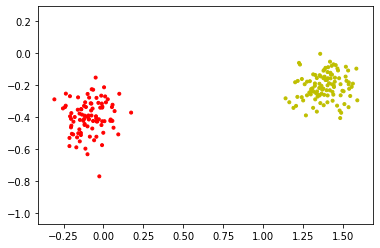

In [1486]:
blah.Plot(idx=(0,1));

# Create Network

In [1487]:
ds = SimpleDataset(A, B, n=100, noise=0.1)
dl = DataLoader(ds, batch_size=10, shuffle=True)

In [1488]:
net = PCNetwork.PCNetwork()
net.AddLayer(PCLayer.PCLayer(n=ds.input_dim))  # v0 input
net.AddLayer(PCLayer.PCLayer(n=ds.n_classes))  # e1 error
net.AddLayer(PCLayer.PCLayer(n=ds.n_classes))  # v1 class

af0 = 'identity'
af = 'identity'
net.Connect(v_idx=0, e_idx=1, type='general', sym=True, act_text=af0)
#net.Connect(v_idx=2, e_idx=1, type='1to1')
net.Connect(v_idx=2, e_idx=1, type='general', sym=True, act_text=af)
#net.con[1].SetIdentity()

net.SetTau(0.05)

# Training

In [1489]:
#net.Plot(idx=0);

In [1490]:
net.ClearHistory()
net.Probe(True)
net.Learning(True)
net.SetGamma(0.5)

# Connection (v0)--(e1)
net.con[0].SetRandom(random=1.)

# Connection (e1)--(v1)
net.con[1].SetRandom(random=1.)
net.con[1].Learning(False)

#net.lyr[1].SetBias(random=0.5)

net.SetDynamicWeightDecay(0.0, 0.0)
net.SetActivityDecay(0.0)
net.SetBlackout(1.)

In [1491]:
M0 = deepcopy(net.con[0].M)
print(M0)
M1 = deepcopy(net.con[1].M)
print(M1)

tensor([[-1.6165,  0.5988],
        [-1.3776,  0.4151],
        [-0.1178,  0.3259]])
tensor([[ 0.1137, -0.9241],
        [-2.1074, -1.9522]])


In [1492]:
net.Learn(dl, T=4., epochs=3)

Epoch: 0 weight decay = 0.0
Epoch: 1 weight decay = 0.0
Epoch: 2 weight decay = 0.0


In [1493]:
print(net.con[0].M)
print(net.con[1].M)

tensor([[ 0.6020, -0.1812],
        [ 0.2757,  0.6815],
        [-1.5484, -1.3481]])
tensor([[ 0.1137, -0.9241],
        [-2.1074, -1.9522]])


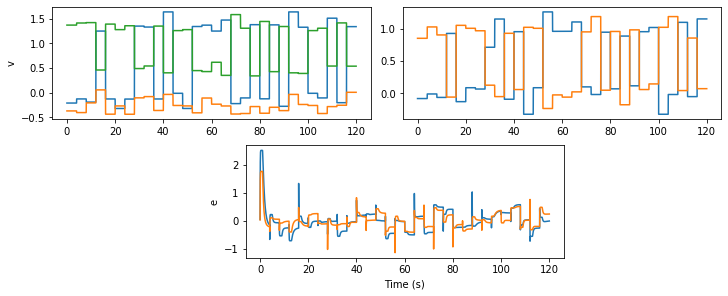

In [1494]:
net.Plot(idx=2);

# Classification

In [1495]:
net.Reset(random=1.)
y = net.Predict(ds.Inputs(), T=10.)
print(y[:16])

tensor([[ 0.9652, -0.0023],
        [ 1.0958, -0.0393],
        [-0.0387,  1.0675],
        [-0.1710,  1.1177],
        [ 1.0837, -0.0107],
        [ 0.9830, -0.0736],
        [ 1.0696, -0.0255],
        [ 1.1358,  0.0254],
        [ 1.0316, -0.0830],
        [-0.0163,  1.1281],
        [ 0.1024,  1.0422],
        [ 1.0753,  0.0166],
        [ 1.1813,  0.0120],
        [ 1.1408, -0.0667],
        [-0.0470,  0.8813],
        [-0.0718,  1.0762]])


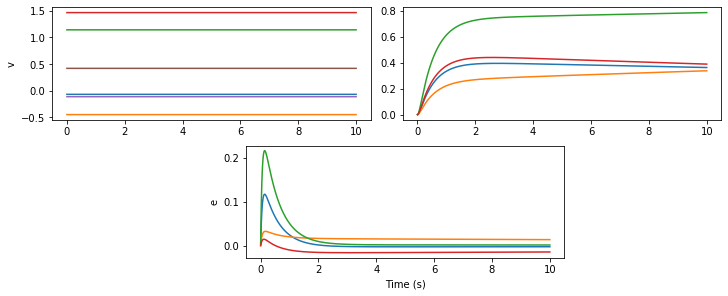

In [1483]:
net.Plot(idx=[1,2]);

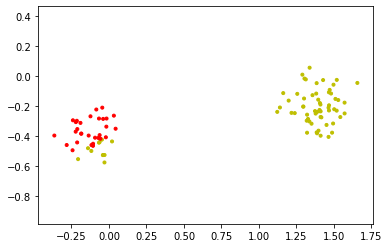

In [1484]:
ds.Plot(labels=y, idx=(0,1))

# Generation

In [205]:
net.Reset(random=1.)
net.SetActivityDecay( (lambda t: 0.2*np.exp(-t)))
X = net.Generate(ds.Targets(), T=10)

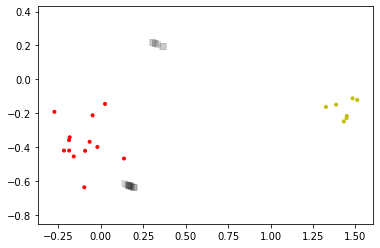

In [206]:
sidx = (0,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

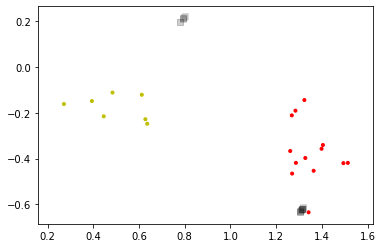

In [207]:
sidx = (2,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

In [208]:
X[:6]

tensor([[ 0.1661, -0.6225,  1.3107],
        [ 0.1514, -0.6168,  1.3152],
        [ 0.1892, -0.6314,  1.3035],
        [ 0.1600, -0.6201,  1.3126],
        [ 0.1738, -0.6254,  1.3083],
        [ 0.1940, -0.6332,  1.3020]])

In [137]:
A

tensor([[ 1.3874, -0.2003,  0.4514],
        [-0.0967, -0.4015,  1.3332]])